In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL

In [42]:
df = pd.read_csv('Data Limpia.csv')
#renombramos las columnas a Fecha y Cantidad de Prescripciones
df.columns = ['Fecha', 'Cantidad de Prescripciones']

In [43]:
df.head(5)

,Fecha,Cantidad de Prescripciones
0,1991-07-01,3.52659
1,1991-08-01,3.18089
2,1991-09-01,3.25222
3,1991-10-01,3.61100
4,1991-11-01,3.56587


In [44]:
df.tail(5)

,Fecha,Cantidad de Prescripciones
199,2008-01-01,21.65429
200,2008-03-01,18.26495
201,2008-04-01,23.10768
202,2008-05-01,22.91251
203,2008-06-01,19.43174


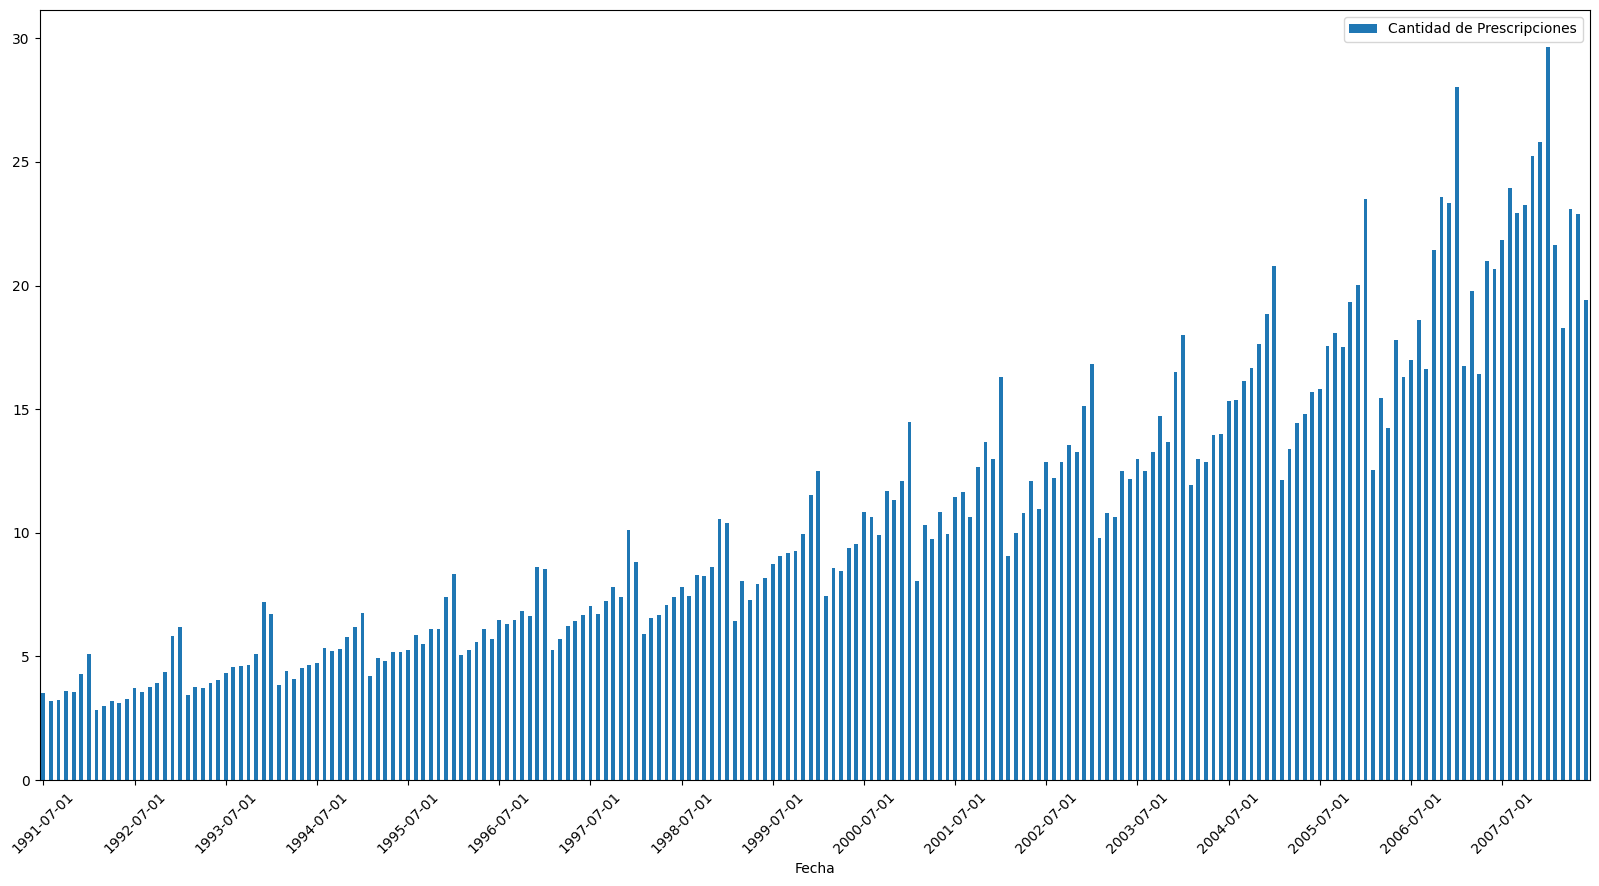

In [45]:
#Gráficamos la distribución de los datos con barras utilizando ambas columnas
df.plot.bar(x='Fecha', y='Cantidad de Prescripciones', rot=45, figsize=(20,10))
x_ticks = plt.gca().get_xticks()
plt.gca().set_xticks(x_ticks[::12])
plt.show()

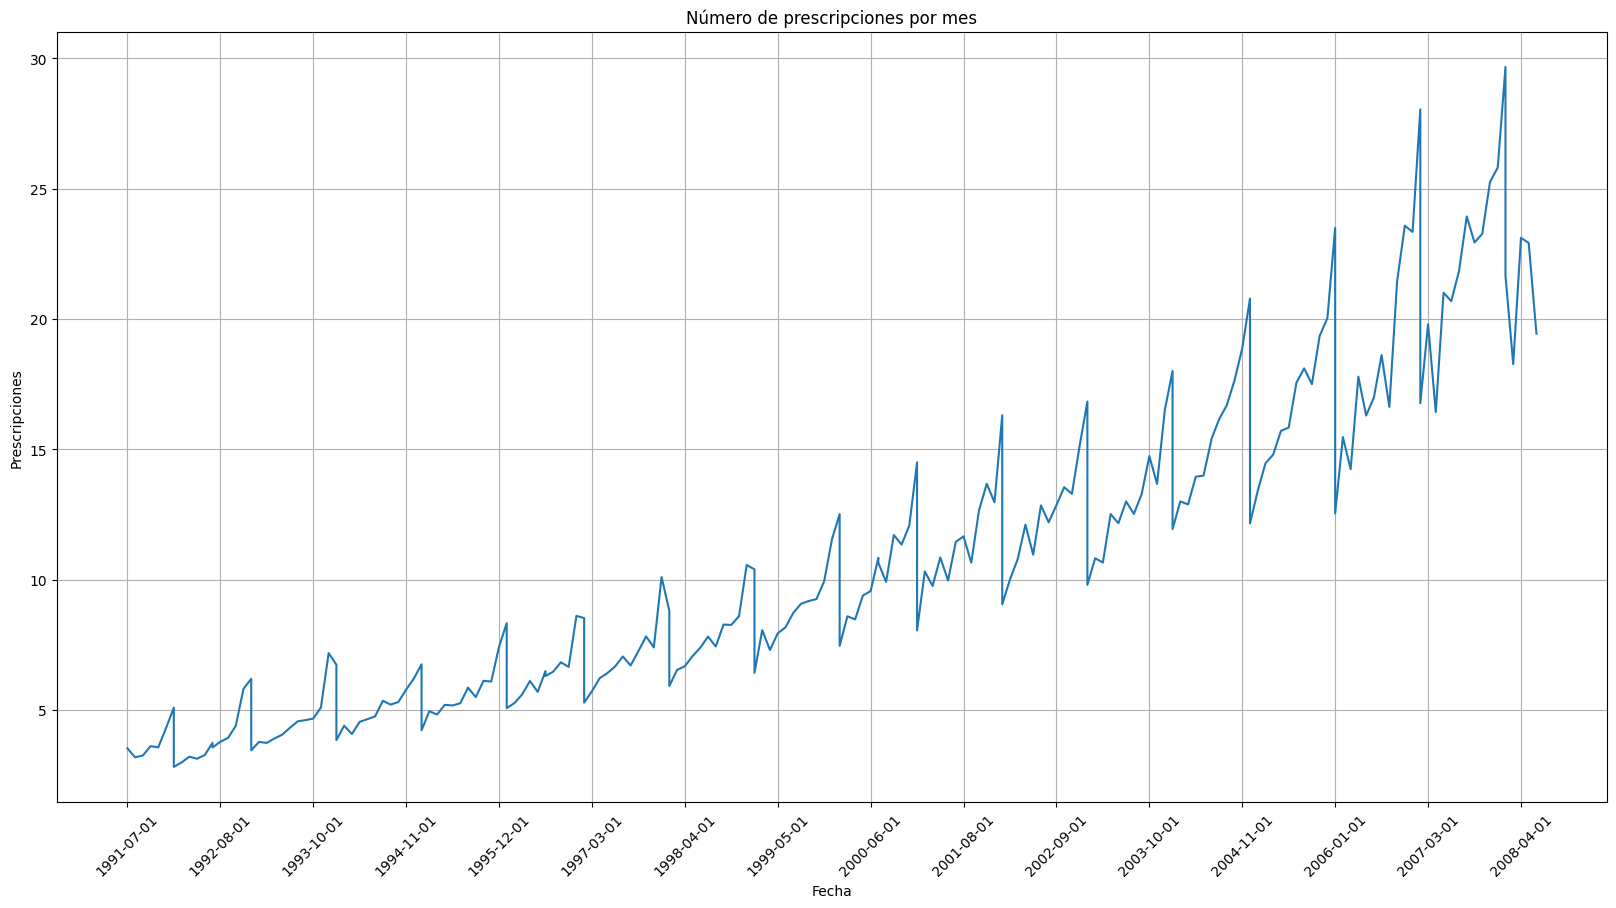

In [46]:
#Utilizamos otro gráfico ya que claramente vemos una tendencia pero no podemos ver los datos con claridad.
#utilizamos un subplot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df['Fecha'], df['Cantidad de Prescripciones'])
ax.set(xlabel='Fecha', ylabel='Prescripciones', title='Número de prescripciones por mes')
ax.grid()
x_ticks = plt.gca().get_xticks()
plt.xticks(rotation=45)
plt.gca().set_xticks(x_ticks[::12])
plt.show()

Observamos que los datos tienen una tendencia estacional, que aumenta con los años. Esta es la principal razón para utilizar SARIMA por sobre ARIMA más adelante ya que el primero es el que toma en consideración la estacionalidad en las series de tiempo (después de todo, SARIMA se desglosa como Seasonal AutoRegressive Integrated Moving Average model).

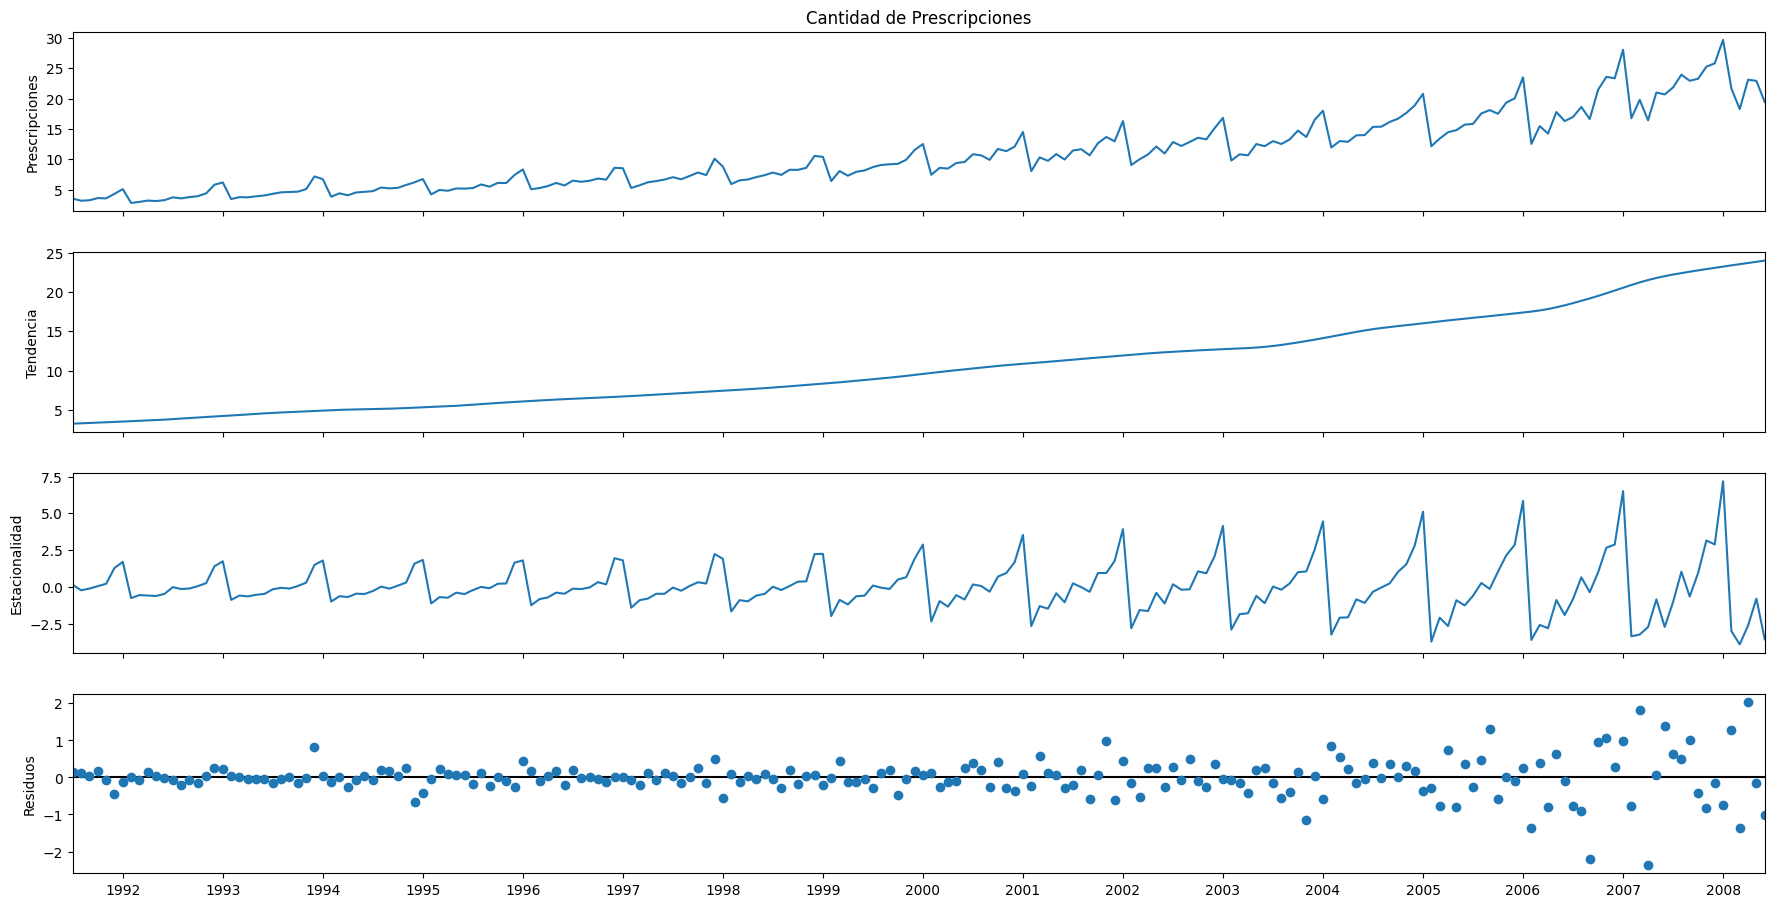

In [47]:
#Utilizaremos el paquete STL de statsmodels para observar las componentes de la serie de tiempo
stl = STL(df['Cantidad de Prescripciones'], period=12)   #periodo de 12 meses
res = stl.fit()
fig = res.plot()

#cambiamos los nombres de las leyendas de cada uno de los graficos
fig.axes[0].set_ylabel('Prescripciones')
fig.axes[1].set_ylabel('Tendencia')
fig.axes[2].set_ylabel('Estacionalidad')
fig.axes[3].set_ylabel('Residuos')
#tamaño de la figura
fig.set_figwidth(20)
fig.set_figheight(10)

#Configurar el eje X con fechas solo por años dentro de la columna Date
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

plt.show()

De lo anterior podemos observar 3 tipos de gráficas:
- La tendencia nos muestra el aumento gradual a lo largo de los años de cantidad de prescripciones.
- La estacionalidad nos muestra patrones repetitivos en los datos a lo largo de un año entre 1991 y 2008.
- Finalmente, el Residuo nos muestra lo errático que se va volviendo el pronóstico, el residuo nos indica la diferencia entre los valores reales y pronosticados a través de la tendencia y la estacionalidad.

Ahora queremos desarrollar el modelo, para ello, debemos empezar por ver que nuestra data presentada no tenga tendencia, sea estacional y no tenga autocorrelación entre sus datos, aplicamos de esta forma el método ADF comprobarlo. ADF nos ayuda a comprobar si es que existe tendencia y estacionalidad en la serie de tiempo.

In [48]:
from statsmodels.tsa.stattools import adfuller

#Función para probar la estacionaridad de la serie de tiempo
ADF = adfuller(df['Cantidad de Prescripciones'])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: 3.145190
p-value: 1.000000


Ambos valores nos indican que nuestra data no es estacionaria y que existe una tendencia en los datos, ADF utiliza hipótesis para comprobar ambos dos, si esque un p-value menor a 0, se puede rechazar lo que llamamos *hipótesis nula* y confirmar que se trata de una serie de tiempo estacional y sin tendencia, eso y cumplir que el ADF statistic es un valor en los negativos.

Aquí aplicamos un método de transformación para que la serie de tiempo sea estacionaria, utilizando la diferenciación

In [49]:
Diff = np.diff(df['Cantidad de Prescripciones'],1)
ADF = adfuller(Diff)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -2.495174
p-value: 0.116653


Los valores cambian para mejor, tomando en consideración que esperamos que el p-value disminuyera y que ADFS tomará valor negativo, sin embargo, aun no cumple lo suficientes requisitos como para ser totalmente estacionaria, por lo que haremos el tratamiento nuevamente.

Para el siguiente tratamiento tomaremos n=12 utilizando la diferenciación ya realizada, esto lo hacemos ya que la data es obtenida de forma mensual, teniendo así 12 meses en el año.

In [50]:
Season_Diff = np.diff(df['Cantidad de Prescripciones'],12)
ADF = adfuller(Season_Diff)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -18.779673
p-value: 0.000000


Ahora podemos confirmar que nuestra serie de tiempo es estacionaria luego de realizar 1 diferenciación, y 1 diferenciación estacional (d=1 y D=1)

Para el entrenamiento del modelo no podemos ocupar el clásico train_test_split, esto porque es imperativo que las series de tiempo sean trabajadas en orden, el TTS toma porcentajes aleatorios de la muestra como train y test, pero para casos de este proyecto, se debe tomar un entrenamiento con cierto porcentaje de la data desde su valor inicial hasta un valor arbitrario, de acuerdo a lo que sea pertinente al modelo.

Tenemos data de 204 meses, por lo que utilizaremos 156 meses para el entrenamiento y los ultimos 4 años para realizar las pruebas.

In [51]:
train = df['Cantidad de Prescripciones'][:156]
test = df['Cantidad de Prescripciones'][156:]

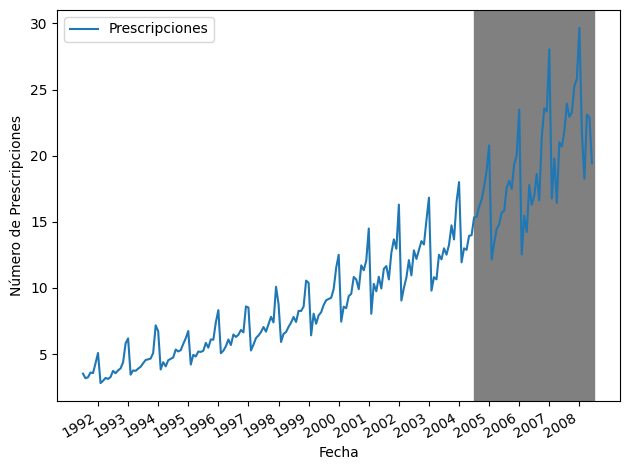

In [52]:
fig, ax = plt.subplots()

ax.plot(df['Cantidad de Prescripciones'], label='Prescripciones')
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de Prescripciones')
ax.axvspan(156, 204, color='grey')
fig.autofmt_xdate()

plt.legend()
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.tight_layout()

La sección en gris es el grupo de entramiento utilizado para el test.